# Recommender System with Collaborative filtering algorithm (MovieLens 100k dataset)

MovieLens dataset - a classic dataset for training recommendation models consisting of 100,000 movie ratings by users (on a 1-5 scale) is used. The main data file consists of a tab-separated list with user-id (starting at 1), item-id (starting at 1), rating, and timestamp as the four fields.

# I. Loading the dataset

In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
# for interactive inline plots
#%matplotlib notebook  
# for simple inline plots
%matplotlib inline 
import seaborn as sns
import time, math
#from IPython.display import display

In [56]:
# Loading ratings
names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', names=names, encoding='latin-1')

# Loading movies info
item_info = pd.read_csv('ml-100k/u.item', sep='|', header=None, usecols=[1], encoding='latin-1')   # Information about the items (keeps only movie's name)
item_info.columns = ['title']

# II. Descriptive analysis

In [57]:
ratings_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [58]:
ratings_df.shape

(100000, 4)

In [59]:
n_users = len(ratings_df['user_id'].unique())
n_items = len(ratings_df['item_id'].unique())
R_shape = (n_users, n_items)
print (str(n_users) + ' users')
print (str(n_items) + ' items')

943 users
1682 items


943 users gave ratings to 1682 movies. There are 100,000 ratings in total.

In [60]:
ratings_df['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

The average rating is 3.52 on a scale from 1.0 to 5.0, with a standard deviation of 1.12. The median rating is 4.0.

##### Visualizing ratings distribution

Text(0.5, 1.0, 'Distribution of ratings')

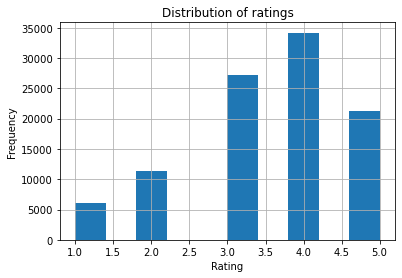

In [61]:
ratings_df['rating'].hist(grid=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of ratings')

##### Visualizing ratings after normalization

Text(0.5, 1.0, 'Distribution of normalized ratings')

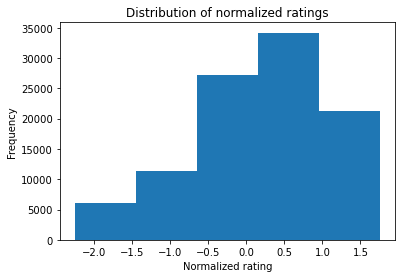

In [62]:
from sklearn.preprocessing import scale
binwidth = 0.8
data = scale(ratings_df['rating'].astype(float))
plt.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth))    # Z-score normalization
plt.xlabel('Normalized rating')
plt.ylabel('Frequency')
plt.title('Distribution of normalized ratings')

##### Movie titles

Showing movies title:

In [63]:
item_info.head()

,title
0,Toy Story (1995)
1,GoldenEye (1995)
2,Four Rooms (1995)
3,Get Shorty (1995)
4,Copycat (1995)


##### Defining X and y

We can define a predictor X and a target variable y:

In [64]:
X = ratings_df[['user_id', 'item_id']].values
y = ratings_df['rating'].values


print ('X'  ,X)

print ('y'  ,y)

X [[ 196  242]
 [ 186  302]
 [  22  377]
 ...
 [ 276 1090]
 [  13  225]
 [  12  203]]
y [3 3 1 ... 1 2 3]


In [65]:
X.shape

(100000, 2)

##### Defining a Rating matrix R

Most recommendation models consist of building a user-by-item matrix with some sort of "interaction" number in each cell. Here, users give items numerical ratings, this is called an explicit feedback model. We can build a user-item (or rating) matrix as follows:

| R           | Item #1           | ...  |  Item #n | 
| --- |  :---:  :---:       | :---: |
| User #1      |  ... | ...  | ... |
| ...      | ... |      ...      |   ... |
| User #m | ... | ...     |  ... |

In [66]:
from scipy import sparse

def ConvertToDense(X, y, shape):  # from R=(X,y), in sparse format 
    row  = X[:,0]
    col  = X[:,1]
    data = y
    matrix_sparse = sparse.csr_matrix((data,(row,col)), shape=(shape[0]+1,shape[1]+1))  # sparse matrix in compressed format (CSR)
    R = matrix_sparse.todense()   # convert sparse matrix to dense matrix, same as: matrix_sparse.A
    R = R[1:,1:]                  # removing the "Python starts at 0" offset
    R = np.asarray(R)             # convert matrix object to ndarray object
    return R
  
n_users = len(ratings_df['user_id'].unique())
n_items = len(ratings_df['item_id'].unique())
R_shape = (n_users, n_items)

R = ConvertToDense(X, y, R_shape)
print (R)
print (R.shape)

[[5 3 4 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]]
(943, 1682)


In [67]:
print (R[1,0])

4


As expected, the rating of movie #1 from user #2 is 4. (Note that the index is shifted by 1)

##### Computing the sparsity of R

In [68]:


print (len(R.nonzero()[0]) / float(R.shape[0] * R.shape[1]))

0.06304669364224531


Sparsity is 6.3%. This means that 6.3% of the user-item ratings have a value. **Note that, although we filled in missing ratings as 0, we should not assume these values to truly be zero. They are just empty entries. As mentioned earlier, ratings are defined from 1 to 5.**


# III. Model-based Collaborative Filtering (Matrix Factorization approach)

In the Matrix Factorization approach, the idea is to find 2 matrices X and $\Theta$ such as R ~ X . $\Theta$.T.  
X contains the features of the items. $\Theta$ contains the features of the users. The idea is to learn latent factors of users (Theta) and latent factors of items (X), so the product of the two can fit the know data.  
Matrix factorization algorithm can use stochastic gradient descent algorithm: One way to approach this problem is the first intialize the two matrices with some values, calculate how 'different' their product is to *R*, and then try to minimize this difference iteratively. The gradient descent algorithm aims at finding a local minimum of the difference.  

In this example, we will use Non-Negative Matrix Factorization approach, available in the scikit-learn package.

## 1. Non-Negative Matrix Factorization (NMF, scikit-learn package)

Find two non-negative matrices (W, H) whose product approximates the non-negative matrix R.   
NOTE: since the values of matrix R MUST be all positive, we CAN'T do mean-centering normalization here (although this would improve the accuracy).

In [69]:

from sklearn.decomposition import NMF

nmf_model = NMF(n_components=20)     # starts with 20 latents factors

# Matrix factorization               # V ~ W.H  (Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X. )
nmf_model.fit(R)                     # R can be array-like or sparse, here it is array-like (dense)
Theta = nmf_model.transform(R)       # user latent factors (= W, called the features matrix)
M = nmf_model.components_.T          # item latent factors (= H.T) (H is called the coefficient matrix)

# Making the predictions
R_pred = M.dot(Theta.T)              # See http://stackoverflow.com/questions/24739121/nonnegative-matrix-factorization-in-sklearn
R_pred = R_pred.T                    # same dimensions as R

print ('Item features - M:', M.shape)
print ('User features - Theta:', Theta.shape)

print ('R ~ M * Theta.T:')
print (R_pred.round(2))
print (R_pred.shape)

/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Item features - M: (1682, 20)
User features - Theta: (943, 20)
R ~ M * Theta.T:
[[4.41 1.81 1.48 ... 0.   0.02 0.04]
 [2.32 0.01 0.25 ... 0.02 0.   0.  ]
 [0.17 0.02 0.05 ... 0.01 0.   0.  ]
 ...
 [1.97 0.08 0.31 ... 0.   0.   0.  ]
 [1.69 0.04 0.   ... 0.01 0.   0.  ]
 [1.44 2.11 1.34 ... 0.   0.03 0.03]]
(943, 1682)


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


## 2. Hyperparameter tuning with NMF

### 2.1 Load the data set

In [70]:
def GetShape(filename):
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    df = pd.read_csv(filename, sep='\t', names=names)
    n_users = len(df['user_id'].unique())
    n_items = len(df['item_id'].unique())
    return (n_users, n_items)

def LoadData(filename, R_shape):
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    df = pd.read_csv(filename, sep='\t', names=names)   
    X = df[['user_id', 'item_id']].values
    y = df['rating'].values   
    return X, y, ConvertToDense(X, y, R_shape)
 
R_shape = GetShape('ml-100k/u.data') 
X, y, R = LoadData('ml-100k/u.data', R_shape)     

### 2.2 Split into training and test set

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

R_train = ConvertToDense(X_train, y_train, R_shape)
R_test = ConvertToDense(X_test, y_test, R_shape)

print ('R_train')
print (R_train)
print (R_train.shape)

print ('R_test')
print (R_test)
print (R_test.shape)

R_train
[[5 3 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(943, 1682)
R_test
[[0 0 4 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]]
(943, 1682)


### 2.3 Choose a model: NMF

In [72]:
from sklearn.decomposition import NMF

parametersNMF = {
                    'n_components' : 20,     # number of latent factors
                    'init' : 'random',
                    'random_state': 0,
                    'alpha': 0.01,          # regularization term
                    'l1_ratio' : 0,         # set regularization = L2
                    'solver': 'cd'
                }

estimator = NMF(**parametersNMF)

##### Estimating the error (RMSE) before tuning the hyperparameters

In [73]:
from sklearn.metrics import mean_squared_error

def get_rmse(pred, actual):
    pred = pred[actual.nonzero()].flatten()     # Ignore zero terms
    actual = actual[actual.nonzero()].flatten() # Ignore zero terms
    return np.sqrt(mean_squared_error(pred, actual))

In [74]:
err = 0
n_iter = 0
n_splits = 5
kf = KFold(n_splits)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):   
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Converting sparse array to dense array
    R_train = ConvertToDense(X_train, y_train, R_shape)
    R_test = ConvertToDense(X_test, y_test, R_shape)

    # Training (matrix factorization)
    t0 = time.time()
    estimator.fit(R_train)  
    Theta = estimator.transform(R_train)       # user features
    M = estimator.components_.T                # item features
    print ("Fit in %0.3fs" % (time.time() - t0))
    n_iter = n_iter+estimator.n_iter_

    # Making the predictions
    R_pred = M.dot(Theta.T)
    R_pred = R_pred.T      
    
    # Clipping values                                                    
    R_pred[R_pred > 5] = 5.           # clips ratings above 5             
    R_pred[R_pred < 1] = 1.           # clips ratings below 1

    # Computing the error on the validation set 
    err += get_rmse(R_pred, R_test)
    print (get_rmse(R_pred, R_test))
    
print ("*** RMSE Error : ", err / n_splits)
print ("Mean number of iterations:", n_iter / n_splits)

/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


Fit in 0.847s
2.547839250118285


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


Fit in 0.836s
2.4484620859193598


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


Fit in 0.877s
2.4110197544333034


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


Fit in 0.856s
2.421988287515323
Fit in 0.850s
2.469733605057448
*** RMSE Error :  2.4598085966087435
Mean number of iterations: 200.0


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


### 2.4 Choose cross validation iterator

In [75]:
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit( n_splits=5, test_size=0.25, random_state=0) # 5-fold scheme
ss.get_n_splits(X,y)

5

### 2.5 Grid Search

In [76]:
param =        {
                    'n_components' : [15, 20, 25],
                    'alpha' : [0.001, 0.01, 0.1],
                    'l1_ratio' : [0], 
                    'max_iter' : [15, 20, 25]
                }

# Keep track of RMSE and parameters
grid_search = pd.DataFrame([[0, 0, 0, 0, 0]])
grid_search.columns = ['n_components', 'alpha', 'l1_ratio', 'max_iter'] + ['RMSE']

# nb of folds in ShuffleSplit CV
n_splits  = 5     
i = 0

# Performing the Grid search
for n_components in param['n_components']:
    for alpha in param['alpha']:
        for l1_ratio in param['l1_ratio']:
            for max_iter in param['max_iter']:

                err = 0
                n_iter = 0
                print ('Search', i, '/', 3 ** 3 - 1)
                for train_index, test_index in ss.split(X,y):
    
                    X_train_ss, X_test_ss = X[train_index], X[test_index]
                    y_train_ss, y_test_ss = y[train_index], y[test_index]
    
                    # Converting sparse array to dense array
                    R_train = ConvertToDense(X_train_ss, y_train_ss, R_shape)
                    R_test = ConvertToDense(X_test_ss, y_test_ss, R_shape)

                    # updating the parameters
                    parametersNMF = {
                    'n_components' : n_components,
                    'init' : 'random', 
                    'random_state' : 0, 
                    'alpha' : alpha,
                    'l1_ratio' : l1_ratio,
                    'max_iter' : max_iter}
                    estimator = NMF(**parametersNMF)
                
                    # Training (matrix factorization)
                    t0 = time.time()
                    estimator.fit(R_train)  
                    Theta = estimator.transform(R_train)       # user features
                    M = estimator.components_.T                # item features
                    #print "Fit in %0.3fs" % (time.time() - t0)
                    n_iter += estimator.n_iter_ 

                    # Making the predictions
                    R_pred = M.dot(Theta.T).T
                    
                    # Clipping values                                                    
                    R_pred[R_pred > 5] = 5.           # clips ratings above 5             
                    R_pred[R_pred < 1] = 1.           # clips ratings below 1

                    # Computing the error on the validation set 
                    err += get_rmse(R_pred, R_test)
    
                #print "RMSE Error : ", err / n_folds
                grid_search.loc[i] = [n_components, alpha, l1_ratio, max_iter, err / n_splits]
                print( grid_search.loc[i].tolist(), "Mean number of iterations:", n_iter / n_splits)
                i += 1

best_params = grid_search.sort_values('RMSE')[:1]

print ('*** best params ***  :',best_params)

Search 0 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 15 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

[15.0, 0.001, 0.0, 15.0, 2.4171804516490822] Mean number of iterations: 15.0
Search 1 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 20 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

[15.0, 0.001, 0.0, 20.0, 2.4160247733334357] Mean number of iterations: 20.0
Search 2 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated i

[15.0, 0.001, 0.0, 25.0, 2.415261256250394] Mean number of iterations: 25.0
Search 3 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 15 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

[15.0, 0.01, 0.0, 15.0, 2.4172053164630096] Mean number of iterations: 15.0
Search 4 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 20 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alp

[15.0, 0.01, 0.0, 20.0, 2.416048260956595] Mean number of iterations: 20.0
Search 5 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

[15.0, 0.01, 0.0, 25.0, 2.415284642719232] Mean number of iterations: 25.0
Search 6 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 15 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 15 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated i

[15.0, 0.1, 0.0, 15.0, 2.417455034066946] Mean number of iterations: 15.0
Search 7 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 20 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

[15.0, 0.1, 0.0, 20.0, 2.41628185785686] Mean number of iterations: 20.0
Search 8 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

[15.0, 0.1, 0.0, 25.0, 2.415514901327386] Mean number of iterations: 25.0
Search 9 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 15 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 15 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated i

[20.0, 0.001, 0.0, 15.0, 2.4218912559377963] Mean number of iterations: 15.0
Search 10 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 20 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

[20.0, 0.001, 0.0, 20.0, 2.4200565921519903] Mean number of iterations: 20.0
Search 11 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

[20.0, 0.001, 0.0, 25.0, 2.418702141855141] Mean number of iterations: 25.0
Search 12 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 15 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 15 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated i

[20.0, 0.01, 0.0, 15.0, 2.4218738413862395] Mean number of iterations: 15.0
Search 13 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 20 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

[20.0, 0.01, 0.0, 20.0, 2.4200561156656515] Mean number of iterations: 20.0
Search 14 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

[20.0, 0.01, 0.0, 25.0, 2.4187204150989823] Mean number of iterations: 25.0
Search 15 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 15 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 15 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated i

[20.0, 0.1, 0.0, 15.0, 2.421770253420056] Mean number of iterations: 15.0
Search 16 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 20 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

[20.0, 0.1, 0.0, 20.0, 2.4201055837539025] Mean number of iterations: 20.0
Search 17 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

[20.0, 0.1, 0.0, 25.0, 2.418920147374645] Mean number of iterations: 25.0
Search 18 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 15 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 15 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of i

[25.0, 0.001, 0.0, 15.0, 2.4260557216579572] Mean number of iterations: 15.0
Search 19 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 20 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 20 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated i

[25.0, 0.001, 0.0, 20.0, 2.424141887149742] Mean number of iterations: 20.0
Search 20 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated i

[25.0, 0.001, 0.0, 25.0, 2.423436377476789] Mean number of iterations: 25.0
Search 21 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 15 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 15 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of i

[25.0, 0.01, 0.0, 15.0, 2.42605774172564] Mean number of iterations: 15.0
Search 22 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 20 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

[25.0, 0.01, 0.0, 20.0, 2.424134022313882] Mean number of iterations: 20.0
Search 23 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated i

[25.0, 0.01, 0.0, 25.0, 2.423418457374927] Mean number of iterations: 25.0
Search 24 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 15 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 15 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of i

[25.0, 0.1, 0.0, 15.0, 2.426085744425047] Mean number of iterations: 15.0
Search 25 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 20 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

[25.0, 0.1, 0.0, 20.0, 2.4240733709085687] Mean number of iterations: 20.0
Search 26 / 26


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated i

[25.0, 0.1, 0.0, 25.0, 2.4232790073601134] Mean number of iterations: 25.0
*** best params ***  :    n_components  alpha  l1_ratio  max_iter      RMSE
2          15.0  0.001       0.0      25.0  2.415261


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


In [77]:
parametersNMF_opt = {
                    'n_components' : 15,     # number of latent factors
                    'init' : 'nndsvd', 
                    'random_state' : 0, 
                    'alpha' : 0.001,          # regularization term
                    'l1_ratio' : 0,          # set regularization = L2 
                    'max_iter' : 25,
                    'solver': 'cd'    
                }

### 2.6 Final evaluation on the test set

In [78]:
estimator = NMF(**parametersNMF_opt)
                
# Training (matrix factorization)
estimator.fit(R_train)  
Theta = estimator.transform(R_train)       # user features
M = estimator.components_.T                # item features

# Making the predictions
R_pred = M.dot(Theta.T).T
                    
# Clipping values                                                    
R_pred[R_pred > 5] = 5.           # clips ratings above 5             
R_pred[R_pred < 1] = 1.           # clips ratings below 1

# Computing the error on the test set 
print ('RMSE test:', get_rmse(R_pred, R_test))

/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


RMSE test: 2.4153313300895065


/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


### 2.7 Train the final model on whole dataset

In [79]:
estimator = NMF(**parametersNMF_opt)
                
# Training (matrix factorization)
estimator.fit(R)  
Theta = estimator.transform(R)            # user features
M = estimator.components_.T               # item features

# Making the predictions
R_pred = M.dot(Theta.T).T
                    
# Clipping values                                                    
R_pred[R_pred > 5] = 5.           # clips ratings above 5             
R_pred[R_pred < 1] = 1.           # clips ratings below 1

/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn(
/Users/nimshaj/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(



## 3. Making item (movie) recommendations

### 3.1 Item recommendation for an active user (given its rating history)

Here the recommendations are based on the prediction of the model with the lowest RMSE

In [80]:
def make_recommendation_activeuser(R, prediction, user_idx, k=5):
    '''
    user_idx ...... select an active user
    k  ............ number of movies to recommend
    '''
    rated_items_df_user = pd.DataFrame(R).iloc[user_idx, :]                 # get the list of actual ratings of user_idx (seen movies)
    user_prediction_df_user = pd.DataFrame(prediction).iloc[user_idx,:]     # get the list of predicted ratings of user_idx (unseen movies)
    reco_df = pd.concat([rated_items_df_user, user_prediction_df_user, item_info], axis=1)   # merge both lists with the movie's title
    reco_df.columns = ['rating','prediction','title']

    print ('Preferred movies for user #', user_idx)
    print ( reco_df.sort_values(by='rating', ascending=False)[:k] )            # returns the 5 seen movies with the best actual ratings
    print ('Recommended movies for user #', user_idx)
    reco_df = reco_df[ reco_df['rating'] == 0 ]
    print (reco_df.sort_values(by='prediction', ascending=False)[:k] )        # returns the 5 unseen movies with the best predicted ratings
    

make_recommendation_activeuser(R, R_pred, user_idx=5, k=5)
make_recommendation_activeuser(R, R_pred, user_idx=130, k=5)

Preferred movies for user # 5
     rating  prediction                                              title
473       5    4.569114  Dr. Strangelove or: How I Learned to Stop Worr...
492       5    2.453174                               Thin Man, The (1934)
489       5    1.900011                            To Catch a Thief (1955)
488       5    2.167315                                   Notorious (1946)
487       5    2.444389                                Sunset Blvd. (1950)
Recommended movies for user # 5
     rating  prediction                             title
602       0    4.918449                Rear Window (1954)
653       0    4.395626                  Chinatown (1974)
656       0    3.805570  Manchurian Candidate, The (1962)
704       0    3.200593        Singin' in the Rain (1952)
178       0    3.134643        Clockwork Orange, A (1971)
Preferred movies for user # 130
     rating  prediction                        title
285       5    3.829962  English Patient, The (1996)
31